In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant import xtdata
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:

file_dx = 'D:\workspace\TradeX\ezMoney\database\低吸_2025-01-27.csv'
file_jl = 'D:\workspace\TradeX\ezMoney\database\接力_2025-01-27.csv'
file_zz = 'D:\workspace\TradeX\ezMoney\database\追涨_2025-01-27.csv'
files = [file_dx, file_jl, file_zz]

strategies = {}
for file in files:
    df = pd.read_csv(file)
    unique_values = df['sub_strategy_name'].unique().tolist()
    unique_key = df['strategy_name'].unique().tolist()
    strategies[unique_key[0]] = unique_values

def calculate_annualized_return(total_return, total_days):
    import math
    return math.pow(1 + total_return / total_days, 365) - 1

def caculate_returns(returns_df, row, _print = False):
    r = {}
    filter_df = returns_df[returns_df['codes_num'] > 0]
    if len(filter_df) <= 0:
        return r
    cumulative_returns = (1 + filter_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (filter_df[row].mean() - risk_free_rate) / filter_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = filter_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 365

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r
   


In [3]:
from datetime import datetime

file_m = {
    '低吸': file_dx,
    '接力': file_jl,
    '追涨': file_zz
}

period_target = {
    '回测周期': ['7d', '15d', '51m1', '412m1', '411m1', '410m1', '49m1', '48m1', '51m', '412m', '411m', '410m', '49m', '48m'],
    '回测目标': ['l1', 'l2', 'l3', 'avg', 'pl1', 'pl2', 'pl3', 'pavg']
}
current_date = datetime.now()
def get_df_by_period(period, sdf, strategy, sub_strategy):
    df = sdf[(sdf['strategy_name'] == strategy) & (sdf['sub_strategy_name'] == sub_strategy)]
    if '7d' == period:
        return df[df['date'] >= current_date - pd.Timedelta(days=7)]    
    elif '15d' == period:
        return df[df['date'] >= current_date - pd.Timedelta(days=15)]
    elif '51m1' == period:
        start_date = pd.to_datetime('2025-01-01')
        return df[df['date'] >= start_date]
    elif '412m1' == period:
        start_date = pd.to_datetime('2024-12-01')
        return df[df['date'] >= start_date]
    elif '411m1' == period:
        start_date = pd.to_datetime('2024-11-01')
        return df[df['date'] >= start_date]
    elif '410m1' == period:
        start_date = pd.to_datetime('2024-10-01')
        return df[df['date'] >= start_date]
    elif '49m1' == period:
        start_date = pd.to_datetime('2024-09-01')
        return df[df['date'] >= start_date]
    elif '48m1' == period:
        start_date = pd.to_datetime('2024-08-01')
        return df[df['date'] >= start_date]
    elif '51m' == period:
        start_date = pd.to_datetime('2025-01-01')
        end_date = pd.to_datetime('2025-01-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '412m' == period:
        start_date = pd.to_datetime('2024-12-01')
        end_date = pd.to_datetime('2024-12-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '411m' == period:
        start_date = pd.to_datetime('2024-11-01')
        end_date = pd.to_datetime('2024-11-30')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '410m' == period:
        start_date = pd.to_datetime('2024-10-01')
        end_date = pd.to_datetime('2024-10-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '49m' == period:
        start_date = pd.to_datetime('2024-09-01')
        end_date = pd.to_datetime('2024-09-30')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    elif '48m' == period:
        start_date = pd.to_datetime('2024-08-01')
        end_date = pd.to_datetime('2024-08-31')
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    else:
        return df

target_row = {
    'l1': 'first_return',
    'l2': 'top2_return',
    'l3': 'top3_return',
    'avg': 'return',
    'pl1': 'p_first_return',
    'pl2': 'p_top2_return',
    'pl3': 'p_top3_return',
    'pavg': 'p_return'
}


columns = {
    '交易名称': 'string',
    '子交易名称': 'string',
    '回测周期': 'string',
    '回测目标': 'string',
    '最大回撤': 'double',
    '夏普比率': 'double',
    '年化收益率': 'double',
    '总收益率': 'double',
    '波动率': 'double',
    '总盈亏': 'double',
    '成功次数': 'int64',
    '失败次数': 'int64',
    '胜率': 'double',
    '总天数': 'int64',
    '总交易次数': 'int64',
    '交易频率': 'double',
    '平均盈利': 'double',
    '平均亏损': 'double',
    '最大盈利': 'double',
    '最大亏损': 'double',
    '盈亏比': 'double',
    '凯利公式最佳仓位': 'double'
}

eval_df = pd.DataFrame(columns=columns.keys()).astype(columns)

for strategy, sub_strategies in strategies.items():
    file = file_m[strategy]
    df = pd.read_csv(file, dtype={'code': 'string'})
    df['date']  = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df['p_first_return'] = df['first_return'] * df['position']
    df['p_top2_return'] = df['top2_return'] * df['position']
    df['p_top3_return'] = df['top3_return'] * df['position']
    df['p_return'] = df['return'] * df['position']
    
    for sub_strategy in sub_strategies:
        for period in period_target['回测周期']:
            print(f"开始评估..., 策略-{strategy} 子策略-{sub_strategy} 日期-{period}")
            ndf = get_df_by_period(period, df, strategy, sub_strategy)
            for target in period_target['回测目标']:
                dt = caculate_returns(ndf, target_row[target])
                if not dt or len(dt) == 0:
                    print(f"策略-{strategy} 子策略-{sub_strategy} 日期-{period} 目标-{target} 结果为空")
                    continue
                dt['交易名称'] = strategy
                dt['子交易名称'] = sub_strategy
                dt['回测周期'] = period
                dt['回测目标'] = target
                cdf = pd.DataFrame([dt])
                eval_df = pd.concat([eval_df, cdf], ignore_index=True)

eval_df.to_csv(r'D:\workspace\TradeX\ezMoney\database\eval_results\eval_0127.csv')

开始评估..., 策略-低吸 子策略-绿盘低吸 日期-7d
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-15d
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-51m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-412m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-411m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-410m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-49m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-48m1
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-51m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-412m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-411m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-410m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-49m
开始评估..., 策略-低吸 子策略-绿盘低吸 日期-48m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-7d
开始评估..., 策略-低吸 子策略-首红断低吸 日期-15d
开始评估..., 策略-低吸 子策略-首红断低吸 日期-51m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-412m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-411m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-410m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-49m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-48m1
开始评估..., 策略-低吸 子策略-首红断低吸 日期-51m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-412m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-411m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-410m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-49m
开始评估..., 策略-低吸 子策略-首红断低吸 日期-48m
开始评估..., 策略-低吸 子策略-红断低吸 日期-7d
开始评估..., 策略-低吸 子策略-红断低吸 日期-15d
开始评估..., 策略-低吸 子策略-红断低吸 日期-51m1
开始评

In [121]:
df = pd.read_csv(r'D:\workspace\TradeX\ezMoney\database\eval_results\eval_0127.csv')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
df= df[df['回测目标'] == 'l1'] 
x = df[(df['总交易次数'] >= 3) & (df['回测周期'] == '412m1')].sort_values(by='胜率', ascending=False)
x[(x['胜率'] > 0.5) & (x['总收益率'] > 0.1)]

,Unnamed: 0,交易名称,子交易名称,回测周期,回测目标,最大回撤,夏普比率,年化收益率,总收益率,波动率,总盈亏,成功次数,失败次数,胜率,总天数,总交易次数,交易频率,平均盈利,平均亏损,最大盈利,最大亏损,盈亏比,凯利公式最佳仓位
3744,3744,接力,一进二打板,412m1,l1,-0.100218,0.716672,4.962649,0.516659,0.090364,0.510742,6,1,0.857143,38,7,5.428571,0.092258,-0.100218,0.151631,-0.100218,0.920573,0.701960
4304,4304,接力,首板打板,412m1,l1,-0.100357,0.605303,8.955722,0.932377,0.068827,0.884504,13,4,0.764706,38,17,2.235294,0.067399,-0.041986,0.178804,-0.100357,1.605263,0.618129
2840,2840,低吸,低位孕线低吸,412m1,l1,-0.068613,0.479591,10.371518,1.079774,0.058367,1.028320,21,7,0.750000,38,28,1.357143,0.044472,-0.021446,0.230082,-0.045699,2.073697,0.629442
2504,2504,低吸,最高孕线低吸,412m1,l1,0.000000,0.568035,2.417620,0.251697,0.148158,0.269879,2,1,0.666667,38,3,12.666667,0.135329,-0.018182,0.254054,-0.018182,7.443111,0.621883
4192,4192,接力,孕线,412m1,l1,-0.229114,0.165482,3.960284,0.412304,0.070571,0.360849,23,14,0.621622,38,37,1.027027,0.048961,-0.049572,0.254054,-0.103981,0.987672,0.238520
2296,2296,低吸,低位N字低吸,412m1,l1,-0.241133,0.208955,3.630314,0.377951,0.070300,0.367479,16,10,0.615385,38,26,1.461538,0.050530,-0.042655,0.185633,-0.109785,1.184627,0.290712
3640,3640,接力,中高位连板打板,412m1,l1,-0.224847,0.347427,3.576845,0.372384,0.138671,0.372384,4,3,0.571429,38,7,5.428571,0.156969,-0.080818,0.283622,-0.126263,1.942269,0.350774
3968,3968,接力,N半,412m1,l1,-0.218582,0.203344,5.998350,0.624486,0.082186,0.416253,19,17,0.527778,38,36,1.055556,0.073877,-0.047178,0.208232,-0.109785,1.565912,0.226214
136,136,低吸,首红断低吸,412m1,l1,-0.208076,0.137598,1.634322,0.170149,0.054046,0.133049,13,12,0.520000,38,25,1.520000,0.045582,-0.033268,0.153952,-0.108211,1.370150,0.169674


In [122]:
file_dx = 'D:\workspace\TradeX\ezMoney\database\低吸_2025-01-27.csv'
file_jl = 'D:\workspace\TradeX\ezMoney\database\接力_2025-01-27.csv'
file_zz = 'D:\workspace\TradeX\ezMoney\database\追涨_2025-01-27.csv'

df = pd.read_csv(file_dx)
df = df[df['sub_strategy_name'] == '低位孕线低吸']
df.set_index('date', inplace=True)
df['cumulative_returns'] = (1 + df['return']).cumprod()
df['p_return'] = df['return'] * df['position']
df['p_cumulative_returns'] = (1 + df['p_return']).cumprod()
df['first_cumulative_returns'] = (1 + df['first_return']).cumprod()
df['p_first_return'] = df['first_return'] * df['position']
df['p_first_cumulative_returns'] = (1 + df['p_first_return']).cumprod()
df['p3_return'] = df['return'] * 0.1
df['p3_cumulative_returns'] = (1 + df['p3_return']).cumprod()
df['p3_first_return'] = df['first_return'] * 0.15
df['p3_first_cumulative_returns'] = (1 + df['p3_first_return']).cumprod()
df_g_zero = df[df['codes_num'] > 0]

In [123]:
print("return:")
caculate_returns(df_g_zero, 'return', _print=True)

return:
最大回撤: -39.00%
夏普比率: 0.17
总收益率: 109.94%
年化收益率: 461.25%
波动率: 5.79%
总盈亏: 111.51%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 4.38%
平均亏损: -3.10%
最大盈利: 23.01%
最大亏损: -9.30%
盈亏比: 1.41
凯利公式最佳仓位: 23.62%


{'最大回撤': np.float64(-0.3899718605415255),
 '夏普比率': np.float64(0.17464293263333155),
 '总收益率': np.float64(1.0994103018119539),
 '波动率': np.float64(0.057876116067018216),
 '年化收益率': np.float64(4.612468507601876),
 '总盈亏': np.float64(1.1151395677795422),
 '成功次数': np.int64(47),
 '失败次数': np.int64(38),
 '总天数': np.int64(87),
 '总交易次数': np.int64(85),
 '交易频率': np.float64(1.0235294117647058),
 '胜率': np.float64(0.5529411764705883),
 '平均盈利': np.float64(0.04380404787827448),
 '平均亏损': np.float64(-0.031037481490884495),
 '最大盈利': np.float64(0.2300819061801935),
 '最大亏损': np.float64(-0.0930232558139534),
 '盈亏比': np.float64(1.4113273943035436),
 '凯利公式最佳仓位': np.float64(0.23617638799284135)}

In [124]:
print("p return:")
caculate_returns(df_g_zero, 'p_return', _print=True)
print('-----------------------------------------------------')

p return:
最大回撤: -16.31%
夏普比率: 0.21
总收益率: 102.48%
年化收益率: 429.95%
波动率: 4.20%
总盈亏: 103.94%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 3.03%
平均亏损: -1.70%
最大盈利: 22.91%
最大亏损: -9.30%
盈亏比: 1.79
凯利公式最佳仓位: 30.26%
-----------------------------------------------------


In [125]:
print("first return:")
caculate_returns(df_g_zero, 'first_return', _print=True)
print('-----------------------------------------------------')

first return:
最大回撤: -39.00%
夏普比率: 0.17
总收益率: 109.94%
年化收益率: 461.25%
波动率: 5.79%
总盈亏: 111.51%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 4.38%
平均亏损: -3.10%
最大盈利: 23.01%
最大亏损: -9.30%
盈亏比: 1.41
凯利公式最佳仓位: 23.62%
-----------------------------------------------------


In [126]:
print("p first_return:")
caculate_returns(df_g_zero, 'p_first_return', _print=True)
print('-----------------------------------------------------')

p first_return:
最大回撤: -16.31%
夏普比率: 0.21
总收益率: 102.48%
年化收益率: 429.95%
波动率: 4.20%
总盈亏: 103.94%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 3.03%
平均亏损: -1.70%
最大盈利: 22.91%
最大亏损: -9.30%
盈亏比: 1.79
凯利公式最佳仓位: 30.26%
-----------------------------------------------------


In [127]:
print("p3 return:")
caculate_returns(df_g_zero, 'p3_return', _print=True)
print('-----------------------------------------------------')

p3 return:
最大回撤: -4.68%
夏普比率: 0.17
总收益率: 9.03%
年化收益率: 37.89%
波动率: 0.58%
总盈亏: 9.19%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 0.44%
平均亏损: -0.31%
最大盈利: 2.30%
最大亏损: -0.93%
盈亏比: 1.41
凯利公式最佳仓位: 23.62%
-----------------------------------------------------


In [128]:
print("p3 first return:")
caculate_returns(df_g_zero, 'p3_first_return', _print=True)
print('-----------------------------------------------------')

p3 first return:
最大回撤: -6.95%
夏普比率: 0.17
总收益率: 13.72%
年化收益率: 57.58%
波动率: 0.87%
总盈亏: 13.96%
成功次数: 47
失败次数: 38
总天数: 87
总交易次数: 85
交易频率: 102.35%
胜率: 55.29%
平均盈利: 0.66%
平均亏损: -0.47%
最大盈利: 3.45%
最大亏损: -1.40%
盈亏比: 1.41
凯利公式最佳仓位: 23.62%
-----------------------------------------------------


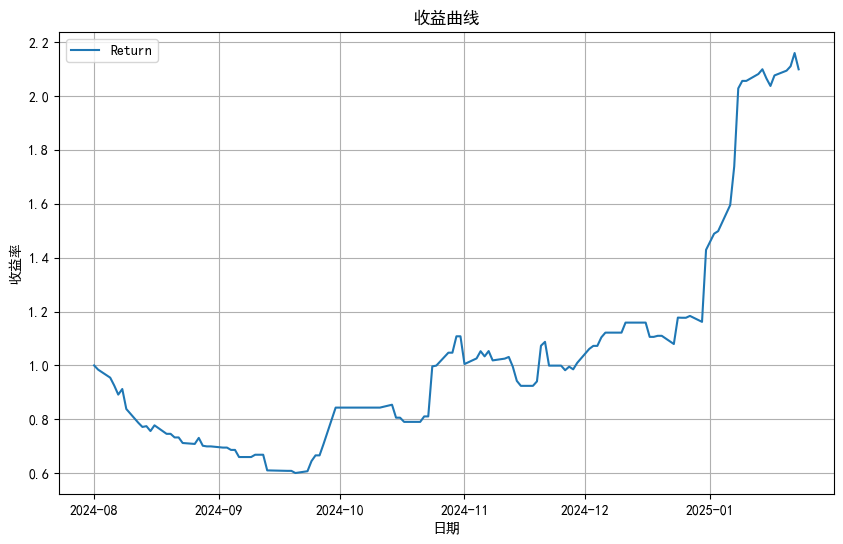

In [129]:
plot(df, 'cumulative_returns')

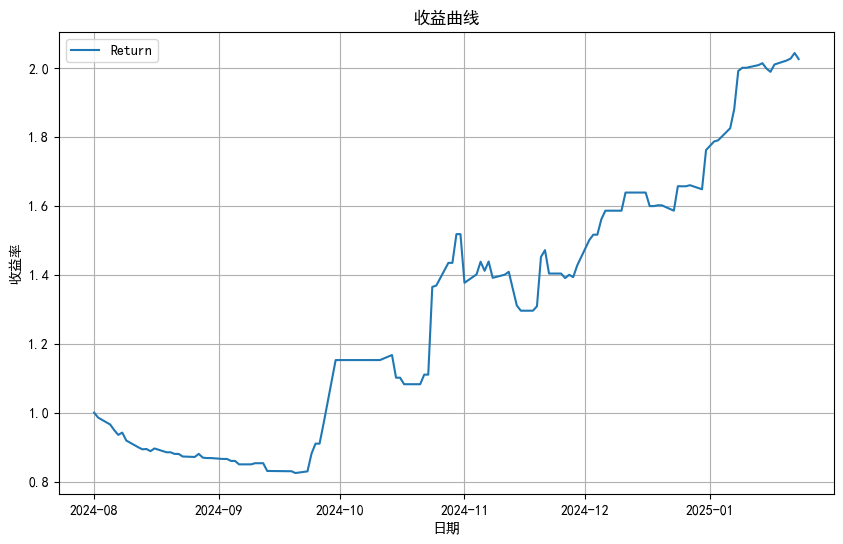

In [130]:
plot(df, 'p_cumulative_returns')

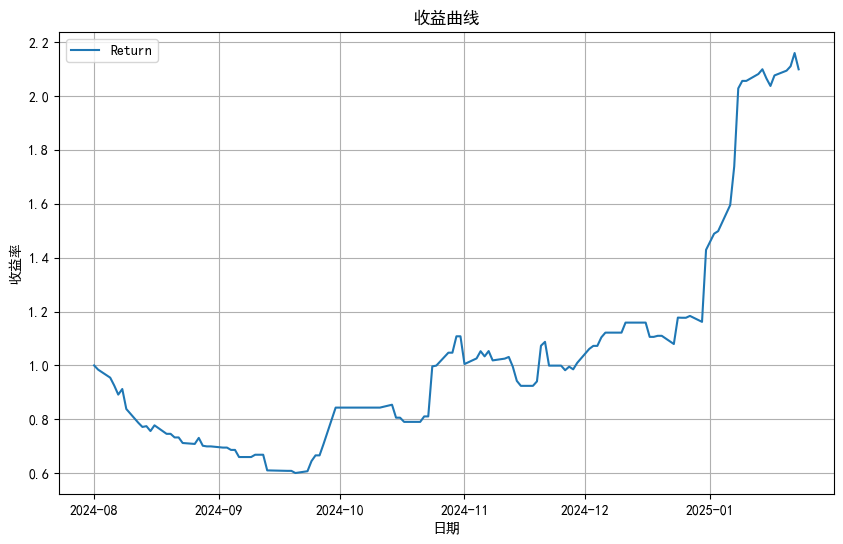

In [131]:
plot(df, 'first_cumulative_returns')

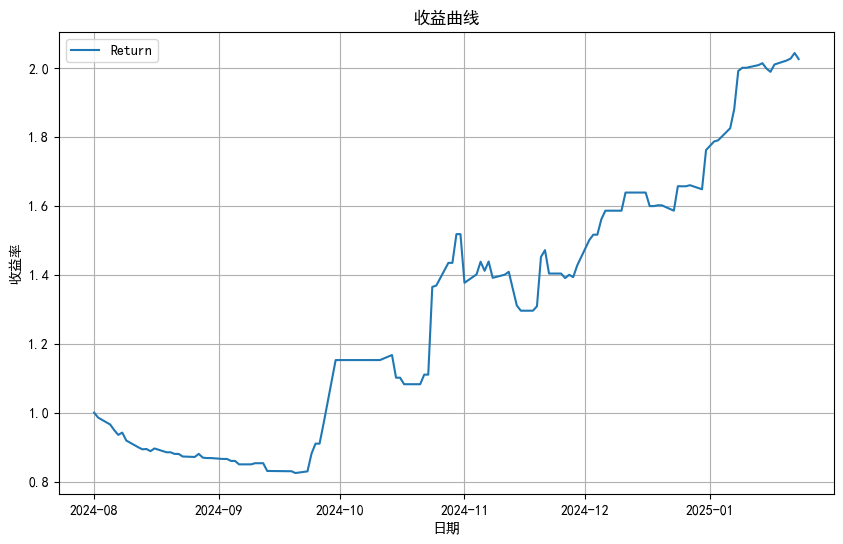

In [132]:
plot(df, 'p_first_cumulative_returns')

In [133]:
len(df_g_zero)

87

In [134]:
len(df)

118

In [135]:
len(df)/len(df_g_zero)

1.3563218390804597

In [136]:
df_after_date = df.loc[df.index >= '2024-11-01']
df_after_date['cumulative_returns'] = (1 + df_after_date['return']).cumprod()
df_after_date['p_return'] = df_after_date['return'] * df_after_date['position']
df_after_date['p_cumulative_returns'] = (1 + df_after_date['p_return']).cumprod()
df_after_date['first_cumulative_returns'] = (1 + df_after_date['first_return']).cumprod()
df_after_date['p_first_return'] = df_after_date['first_return'] * df_after_date['position']
df_after_date['p_first_cumulative_returns'] = (1 + df_after_date['p_first_return']).cumprod()
df_after_date_g_zero = df_after_date[df_after_date['codes_num'] > 0]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_52400\3900913857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_date['cumulative_returns'] = (1 + df_after_date['return']).cumprod()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_52400\3900913857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_date['p_return'] = df_after_date['return'] * df_after_date['position']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_52400\3900913857.py:4: SettingWithCopyWarning: 
A value is t

In [137]:
print("return:")
caculate_returns(df_after_date_g_zero, 'return', True)
print('-------------------------------------------------------------------')

return:
最大回撤: -12.26%
夏普比率: 0.27
总收益率: 89.47%
年化收益率: 694.79%
波动率: 5.66%
总盈亏: 98.77%
成功次数: 31
失败次数: 16
总天数: 47
总交易次数: 47
交易频率: 100.00%
胜率: 65.96%
平均盈利: 3.94%
平均亏损: -3.19%
最大盈利: 23.01%
最大亏损: -9.30%
盈亏比: 1.24
凯利公式最佳仓位: 38.43%
-------------------------------------------------------------------


In [138]:
print("p return:")
caculate_returns(df_after_date_g_zero, 'p_return', True)
print("---------------------------------------------------------------------")


p return:
最大回撤: -9.92%
夏普比率: 0.21
总收益率: 33.45%
年化收益率: 259.79%
波动率: 3.13%
总盈亏: 42.75%
成功次数: 31
失败次数: 16
总天数: 47
总交易次数: 47
交易频率: 100.00%
胜率: 65.96%
平均盈利: 2.13%
平均亏损: -2.18%
最大盈利: 10.94%
最大亏损: -9.30%
盈亏比: 0.98
凯利公式最佳仓位: 31.14%
---------------------------------------------------------------------


In [139]:
print("first return:")
caculate_returns(df_after_date_g_zero, 'first_return', True)
print("----------------------------------------------------------------------")


first return:
最大回撤: -12.26%
夏普比率: 0.27
总收益率: 89.47%
年化收益率: 694.79%
波动率: 5.66%
总盈亏: 98.77%
成功次数: 31
失败次数: 16
总天数: 47
总交易次数: 47
交易频率: 100.00%
胜率: 65.96%
平均盈利: 3.94%
平均亏损: -3.19%
最大盈利: 23.01%
最大亏损: -9.30%
盈亏比: 1.24
凯利公式最佳仓位: 38.43%
----------------------------------------------------------------------


In [140]:
print("p first_return:")
caculate_returns(df_after_date_g_zero, 'p_first_return', True)
print("-----------------------------------------------------------------------")

p first_return:
最大回撤: -9.92%
夏普比率: 0.21
总收益率: 33.45%
年化收益率: 259.79%
波动率: 3.13%
总盈亏: 42.75%
成功次数: 31
失败次数: 16
总天数: 47
总交易次数: 47
交易频率: 100.00%
胜率: 65.96%
平均盈利: 2.13%
平均亏损: -2.18%
最大盈利: 10.94%
最大亏损: -9.30%
盈亏比: 0.98
凯利公式最佳仓位: 31.14%
-----------------------------------------------------------------------


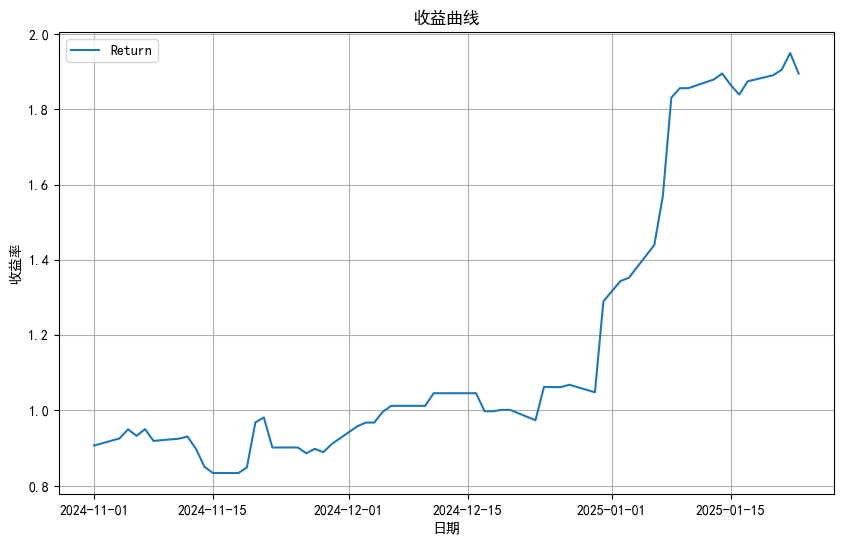

In [141]:
plot(df_after_date, 'cumulative_returns')

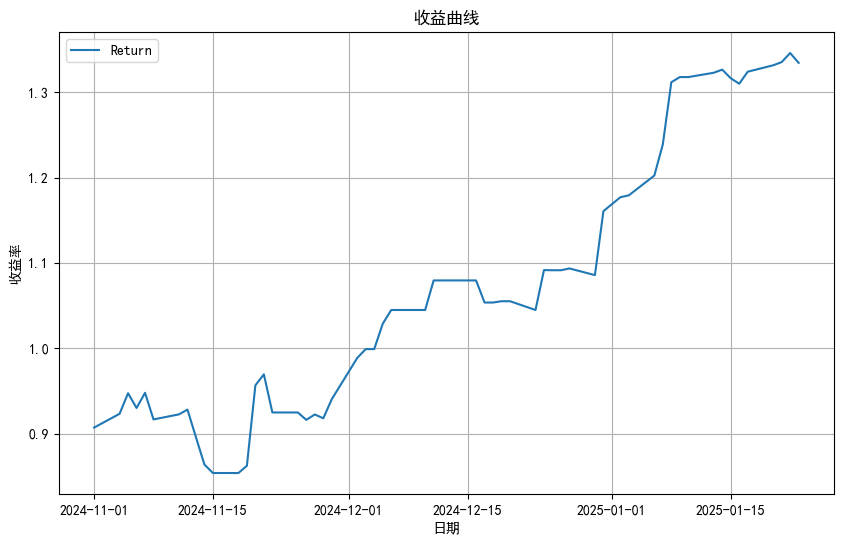

In [142]:
plot(df_after_date, 'p_cumulative_returns')

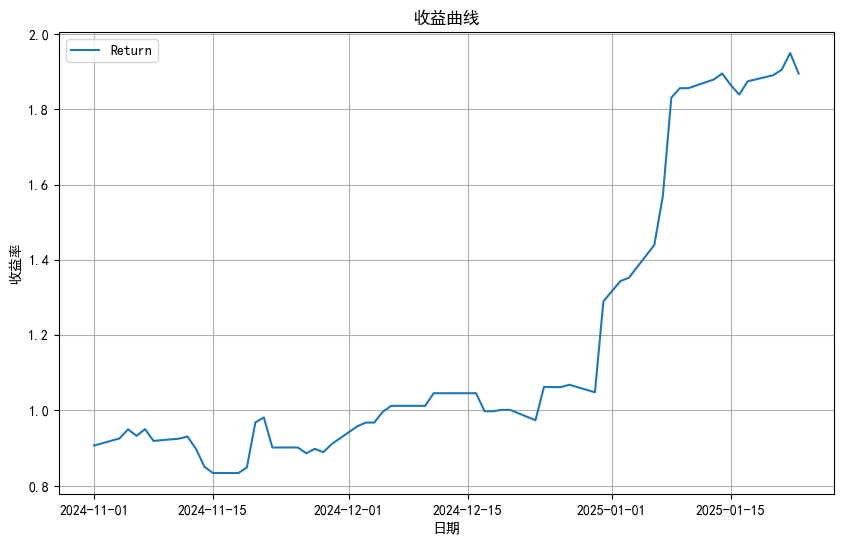

In [143]:
plot(df_after_date, 'first_cumulative_returns')

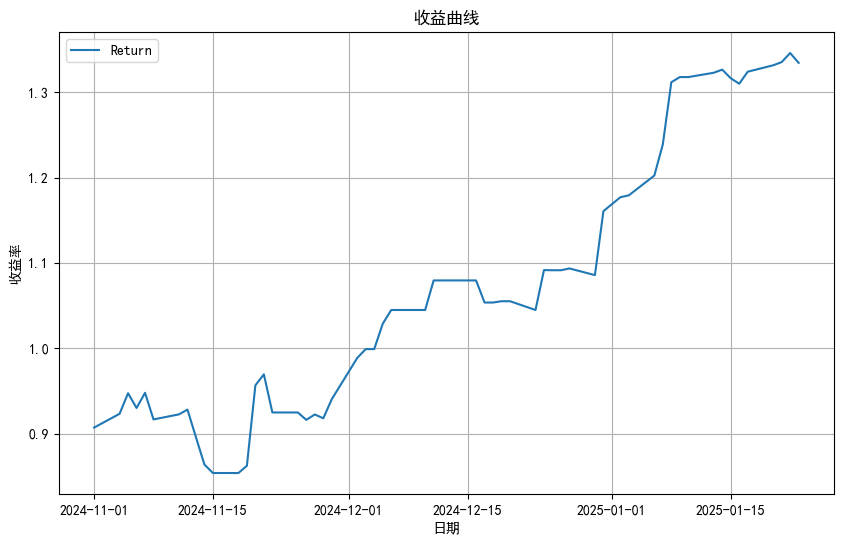

In [144]:
plot(df_after_date, 'p_first_cumulative_returns')

In [145]:
0.008906*0.3

0.0026718

In [146]:
3.61*0.3

1.083

In [147]:
df_g_zero

,code,strategy_name,sub_strategy_name,return,max_return,first_return,top2_return,top3_return,position,codes_num,trendScore,shortLineScore,shortLineScoreChange,cumulative_returns,p_return,p_cumulative_returns,first_cumulative_returns,p_first_return,p_first_cumulative_returns,p3_return,p3_cumulative_returns,p3_first_return,p3_first_cumulative_returns
date,,,,,,,,,,,,,,,,,,,,,,,
2024-08-02,2979.0,低吸,低位孕线低吸,-0.015729,-0.015729,-0.015729,-0.015729,-0.015729,0.927208,1,-1.96,29.57,-2.76,0.984271,-0.014584,0.985416,0.984271,-0.014584,0.985416,-0.001573,0.998427,-0.002359,0.997641
2024-08-05,600684.0,低吸,低位孕线低吸,-0.030201,-0.030201,-0.030201,-0.030201,-0.030201,0.675140,1,-14.82,8.25,-21.32,0.954544,-0.020390,0.965323,0.954544,-0.020390,0.965323,-0.003020,0.995412,-0.004530,0.993121
2024-08-06,829.0,低吸,低位孕线低吸,-0.030588,-0.030588,-0.030588,-0.030588,-0.030588,0.551162,1,-15.31,8.16,-0.09,0.925347,-0.016859,0.949048,0.925347,-0.016859,0.949048,-0.003059,0.992367,-0.004588,0.988564
2024-08-07,2168.0,低吸,低位孕线低吸,-0.036496,-0.036496,-0.036496,-0.036496,-0.036496,0.396782,1,-34.66,-38.99,-47.15,0.891575,-0.014481,0.935305,0.891575,-0.014481,0.935305,-0.003650,0.988745,-0.005474,0.983153
2024-08-08,715.0,低吸,低位孕线低吸,0.023301,0.023301,0.023301,0.023301,0.023301,0.300000,1,-50.64,-60.51,-21.52,0.912349,0.006990,0.941843,0.912349,0.006990,0.941843,0.002330,0.991049,0.003495,0.986589
2024-08-09,759.0,低吸,低位孕线低吸,-0.081325,-0.081325,-0.081325,-0.081325,-0.081325,0.300708,1,-43.04,-42.41,18.10,0.838152,-0.024455,0.918810,0.838152,-0.024455,0.918810,-0.008133,0.982989,-0.012199,0.974554
2024-08-12,2305.0,低吸,低位孕线低吸,-0.061350,-0.061350,-0.061350,-0.061350,-0.061350,0.347628,1,-50.24,-58.96,-16.55,0.786732,-0.021327,0.899215,0.786732,-0.021327,0.899215,-0.006135,0.976959,-0.009202,0.965585
2024-08-13,600696.0,低吸,低位孕线低吸,-0.019318,-0.019318,-0.019318,-0.019318,-0.019318,0.336042,1,-64.55,-75.63,-16.67,0.771534,-0.006492,0.893378,0.771534,-0.006492,0.893378,-0.001932,0.975071,-0.002898,0.962787
2024-08-14,901.0,低吸,低位孕线低吸,0.003711,0.003711,0.003711,0.003711,0.003711,0.300000,1,-50.93,-58.43,17.20,0.774397,0.001113,0.894372,0.774397,0.001113,0.894372,0.000371,0.975433,0.000557,0.963323


# 不按凯利公式调仓
## return
- 最大回撤: -20.73%
- 夏普比率: 0.09
- 总收益率: 14.75%
- 波动率: 5.90%
- 最大收益: 16.11%
- 总盈亏: 11.40%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 5.08%
- 平均亏损: -4.25%
- 最大盈利: 16.11%
- 最大亏损: -8.12%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p return
- 最大回撤: -13.76%
- 夏普比率: 0.19
- 总收益率: 28.26%
- 波动率: 3.91%
- 最大收益: 14.37%
- 总盈亏: 25.16%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 3.46%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.64
- 凯利公式最佳仓位: 21.61%

## first return
- 最大回撤: -13.93%
- 夏普比率: 0.12
- 总收益率: 23.89%
- 波动率: 5.88%
- 最大收益: 16.11%
- 总盈亏: 20.55%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 4.98%
- 平均亏损: -4.23%
- 最大盈利: 16.11%
- 最大亏损: -9.67%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%

## p first_return
- 最大回撤: -13.74%
- 夏普比率: 0.20
- 总收益率: 31.27%
- 波动率: 3.85%
- 最大收益: 14.37%
- 总盈亏: 28.17%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 3.30%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.55
- 凯利公式最佳仓位: 24.50%

## p3 return
- 最大回撤: -6.54%
- 夏普比率: 0.09
- 总收益率: 5.59%
- 波动率: 1.77%
- 最大收益: 4.83%
- 总盈亏: 4.58%
- 成功次数: 19
- 胜率: 51.35%
- 平均盈利: 1.52%
- 平均亏损: -1.27%
- 最大盈利: 4.83%
- 最大亏损: -2.44%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p3 first return
- 最大回撤: -4.28%
- 夏普比率: 0.12
- 总收益率: 8.05%
- 波动率: 1.76%
- 最大收益: 4.83%
- 总盈亏: 7.04%
- 成功次数: 20
- 胜率: 54.05%
- 平均盈利: 1.50%
- 平均亏损: -1.27%
- 最大盈利: 4.83%
- 最大亏损: -2.90%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%


<!-- return:
最大回撤: -20.73%
夏普比率: 0.04
总收益率: 1.99%
波动率: 5.35%
最大收益: 10.37%
总盈亏: 5.31%
None
p return:
最大回撤: -7.64%
夏普比率: 0.21
总收益率: 14.38%
波动率: 3.52%
最大收益: 10.37%
总盈亏: 17.71%
None
first return:
最大回撤: -12.83%
夏普比率: 0.13
总收益率: 12.16%
波动率: 5.23%
最大收益: 10.37%
总盈亏: 15.49%
None
p first_return:
最大回撤: -4.61%
夏普比率: 0.26
总收益率: 18.58%
波动率: 3.44%
最大收益: 10.37%
总盈亏: 21.91%
None -->


# 按照凯利公式调仓
## return
- 最大回撤: -20.73%
- 夏普比率: 0.09
- 总收益率: 14.75%
- 波动率: 5.90%
- 最大收益: 16.11%
- 总盈亏: 11.40%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 5.08%
- 平均亏损: -4.25%
- 最大盈利: 16.11%
- 最大亏损: -8.12%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p return
- 最大回撤: -13.76%
- 夏普比率: 0.19
- 总收益率: 28.26%
- 波动率: 3.91%
- 最大收益: 14.37%
- 总盈亏: 25.16%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 3.46%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.64
- 凯利公式最佳仓位: 21.61%

## first return
- 最大回撤: -13.93%
- 夏普比率: 0.12
- 总收益率: 23.89%
- 波动率: 5.88%
- 最大收益: 16.11%
- 总盈亏: 20.55%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 4.98%
- 平均亏损: -4.23%
- 最大盈利: 16.11%
- 最大亏损: -9.67%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%

## p first_return
- 最大回撤: -13.74%
- 夏普比率: 0.20
- 总收益率: 31.27%
- 波动率: 3.85%
- 最大收益: 14.37%
- 总盈亏: 28.17%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 3.30%
- 平均亏损: -2.12%
- 最大盈利: 14.37%
- 最大亏损: -4.99%
- 盈亏比: 1.55
- 凯利公式最佳仓位: 24.50%

## p3 return
- 最大回撤: -2.21%
- 夏普比率: 0.09
- 总收益率: 1.96%
- 波动率: 0.59%
- 最大收益: 1.61%
- 总盈亏: 1.62%
- 成功次数: 19
- 总次数: 37
- 胜率: 51.35%
- 平均盈利: 0.51%
- 平均亏损: -0.42%
- 最大盈利: 1.61%
- 最大亏损: -0.81%
- 盈亏比: 1.20
- 凯利公式最佳仓位: 10.67%

## p3 first return
- 最大回撤: -2.15%
- 夏普比率: 0.12
- 总收益率: 4.10%
- 波动率: 0.88%
- 最大收益: 2.42%
- 总盈亏: 3.59%
- 成功次数: 20
- 总次数: 37
- 胜率: 54.05%
- 平均盈利: 0.75%
- 平均亏损: -0.63%
- 最大盈利: 2.42%
- 最大亏损: -1.45%
- 盈亏比: 1.18
- 凯利公式最佳仓位: 15.04%


# 10月15号后
## return
- 最大回撤: -20.73%
- 夏普比率: 0.04
- 总收益率: 1.99%
- 波动率: 5.35%
- 最大收益: 10.37%
- 总盈亏: 5.31%
- 成功次数: 10
- 总次数: 19
- 胜率: 52.63%
- 平均盈利: 4.50%
- 平均亏损: -4.48%
- 最大盈利: 10.37%
- 最大亏损: -8.12%
- 盈亏比: 1.00
- 凯利公式最佳仓位: 5.48%

## p return
- 最大回撤: -7.64%
- 夏普比率: 0.21
- 总收益率: 14.38%
- 波动率: 3.52%
- 最大收益: 10.37%
- 总盈亏: 17.71%
- 成功次数: 10
- 总次数: 19
- 胜率: 52.63%
- 平均盈利: 3.30%
- 平均亏损: -2.04%
- 最大盈利: 10.37%
- 最大亏损: -4.61%
- 盈亏比: 1.62
- 凯利公式最佳仓位: 23.34%

## first return
- 最大回撤: -12.83%
- 夏普比率: 0.13
- 总收益率: 12.16%
- 波动率: 5.23%
- 最大收益: 10.37%
- 总盈亏: 15.49%
- 成功次数: 11
- 总次数: 19
- 胜率: 57.89%
- 平均盈利: 4.49%
- 平均亏损: -4.41%
- 最大盈利: 10.37%
- 最大亏损: -8.12%
- 盈亏比: 1.02
- 凯利公式最佳仓位: 16.54%

## p first_return
- 最大回撤: -4.61%
- 夏普比率: 0.26
- 总收益率: 18.58%
- 波动率: 3.44%
- 最大收益: 10.37%
- 总盈亏: 21.91%
- 成功次数: 11
- 总次数: 19
- 胜率: 57.89%
- 平均盈利: 3.13%
- 平均亏损: -2.03%
- 最大盈利: 10.37%
- 最大亏损: -4.61%
- 盈亏比: 1.54
- 凯利公式最佳仓位: 30.60%
